### Coordinate transformation to spherical coordinates with the pole in the equator

**Coordinates and available information**

1. siu(T), siv(T) -- velocities in the T point
2. lat(T), lon(T) -- latitude and longitude coordinates in the T points 
3. virtual positions x(T), y(T) obtained from the distance vectors e1u, e1v, e1t, e2u, e2v, e2t 


**Goal**

We want to compute siu(lat_rot,lon_rot)  and siv(lat_rot,lon_rot) at any point referenced in a rotated latitude, longitude coordinate system.
lat_rot, lon_rot refer to the final coordinate system with one pole in the equator. We can obtain this by a 90⁰ rotation along the x or y axis (choose) (Rx rotation)

**Steps to follow**
1. Rotate the geographical coordinates (lat(T) and lon(T)) around the x-axis by a 90 degrees.
   Step by step:
      1. Convert the input spherical coordinates into Cartesian coordinates (x,y,z). 
      2. Apply the rotation matrix Rx(90) to the Cartesian coordinates
      3. Convert the rotated Cartesian coordinates back into spherical coordinates (lat_rot(T) and lon_rot(T)). 
    

2. siu(x(T),y(T)), siv(x(T),y(T)) -------------->  siu(lat_rot,lon_rot), siv(lat_rot,lon_rot) with a rotation
   


### Imports

In [73]:
import netCDF4 as nc
from netCDF4 import Dataset
import sys, os
import time
import numpy as np
from numpy import ma 
from numpy import pi

#Import packages for plotting
from matplotlib import pyplot as plt
from pylab import imshow,cm

#Import packages for interpolating
from scipy.interpolate import griddata



In [74]:
# get current directory\n
path = os.getcwd()
# get parent directory
home_directory = os.path.sep.join(path.split(os.path.sep)[:-3])
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-1])
print("Parent directory: "+parent_directory)
parent_directory_end = os.path.sep.join(path.split(os.path.sep)[4:])
#data directory
data_directory = home_directory+'/Data/NeXtSIM/'
# results directory
results_directory = data_directory+'rotated_ice_velocities/'

if not os.path.exists(results_directory):
    os.makedirs(results_directory)

Parent directory: /home/llu/Programs/Spectral_Clustering


In [75]:
# add utils and subfunctions folders to current working path
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")

# Import function for the polar rotation
from ipynb.fs.defs.polar_rotation import polar_rotation_rx , cartesian_to_spherical, spherical_to_cartesian

# Import function to change units
from ipynb.fs.defs.convert_meters_per_second_to_deg_per_day import m_to_deg_r


In [77]:
# Open the NetCDF file
file_name = 'OPA-neXtSIM_CREG025_ILBOXE140_2010_ice.nc'
file_path = data_directory+file_name

dataset = nc.Dataset(file_path, mode='r')

metadata_path =  data_directory+'/mesh_mask_CREG025_3.6_NoMed.nc'  
metadata = nc.Dataset(metadata_path, mode='r')

'OPA-neXtSIM_CREG025_ILBOXE140_2010_ice'

In [31]:
#Parameters to filter timesteps of the velocity vectors
tmin = 0
tmax = 10
freq=1
#Parameters to filter area 
ycut_min = 110
xcut_min = 0
xcut_max = 500

#Read sea ice velocities and directly transform from m/s to m/day
siu = dataset.variables['siu'][tmin:tmax,ycut_min:,xcut_min:xcut_max]*3600*24 
siv = dataset.variables['siv'][tmin:tmax,ycut_min:,xcut_min:xcut_max]*3600*24 
siu = np.transpose(siu, axes=(1, 2, 0))
siv = np.transpose(siv, axes=(1, 2, 0))
siu = siu[:,:,::freq]
siv = siv[:,:,::freq]

# Access specific variables
time_data = dataset.variables['time'][tmin:tmax]
time_data= np.reshape(time_data, (1,-1))
time_data = time_data[0,::freq]

# Access (lat,lon) coordinates in the t point
latitude_t = metadata.variables['nav_lat'][ycut_min:,xcut_min:xcut_max]  
longitude_t = metadata.variables['nav_lon'][ycut_min:,xcut_min:xcut_max]

# Access (lat,lon) coordinates in the v point
longitude_v = metadata.variables['glamv'][0,ycut_min:,xcut_min:xcut_max]
latitude_v = metadata.variables['gphiv'][0,ycut_min:,xcut_min:xcut_max]  

# Access (lat,lon) coordinates in the u point
longitude_u = metadata.variables['glamu'][0,ycut_min:,xcut_min:xcut_max]
latitude_u = metadata.variables['gphiu'][0,ycut_min:,xcut_min:xcut_max]  

# Access grid spacing centered on the t-point from the metadata
e1t = metadata.variables['e1t'][0,ycut_min:,xcut_min:xcut_max]  
e2t = metadata.variables['e2t'][0,ycut_min:,xcut_min:xcut_max]
e1u = metadata.variables['e1u'][0,ycut_min:,xcut_min:xcut_max]  
e2v = metadata.variables['e2v'][0,ycut_min:,xcut_min:xcut_max]

# Close the datasets when done reading
dataset.close()
metadata.close()


### Positive Rx(90⁰) rotation around the x axis. Rotation according to the right hand rule. 
Two possible interpretations:
    - Anticlockwise rotation of the data (NP to the equator in the lon=-90⁰) 
    - Clocwise rotation of the coordinates (y,z). y_r = -z and z_r = y

In [32]:
#Rotation in the v-point
latitude_v_r, longitude_v_r = polar_rotation_rx(latitude_v,longitude_v,90)
#Rotation in the u-point
latitude_u_r, longitude_u_r = polar_rotation_rx(latitude_u,longitude_u,90)
#Rotation in the t-point
latitude_t_r, longitude_t_r = polar_rotation_rx(latitude_t,longitude_t,90)

### Computation of the angle of rotation in the coordinate trasformation (x,y)-->(lat_r,lon_r)

In [33]:
# Discrete differenciation of the rotated coordinates in the u and v points along the x and y directions. #Note that we loose one point in each derivative along 
# the direction of derivation. Therefore we adjust the dimensions in the other direction as well. 
"""
Why do we assume we are loosing the first element of each row? This is related to the distribution of the u and v points around each cell and therefore the t-points. 
Since we are given the same amount of u and v points as t points, one of the lateral borders of the grid can't be sorrounded by u points and one of the vertical borders
of the grid can't be sorrounded by v points. After comparing the gradients of the latiutde (and longitude) with the discrete differences of lat_v_lower_border-lat_t_lower_border
(resp. lon_u_left_border-lon_t_left_border), we concluded that the first t-point comes before the first u-point in the horitzontal direction and before the first v-point
in the vertical direction. Therefore, we remove this first coordinates from the rest of vectors.
"""
dlonx_r = np.diff(longitude_u_r)[1:493,:]
dlony_r = np.diff(longitude_v_r,axis=0)[:,1:500]
dlatx_r = np.diff(latitude_u_r)[1:493,:] 
dlaty_r = np.diff(latitude_v_r,axis=0)[:,1:500] 

# Convert to arrays if they are matrices 
dlatx_r = np.asarray(dlatx_r)
dlonx_r = np.asarray(dlonx_r)
dlaty_r = np.asarray(dlaty_r)
dlony_r = np.asarray(dlony_r)

# Mask the arrays
dlatx_r = np.ma.masked_array(dlatx_r, mask=np.ma.getmask(latitude_v[1:493,1:500])) 
dlonx_r = np.ma.masked_array(dlonx_r, mask=np.ma.getmask(longitude_u[1:493,1:500]))
dlaty_r = np.ma.masked_array(dlaty_r, mask=np.ma.getmask(latitude_v[1:493,1:500])) 
dlony_r = np.ma.masked_array(dlony_r, mask=np.ma.getmask(longitude_u[1:493,1:500]))

# Cut dimensions on the other variables 
e1t = e1t[1:493,1:500] 
e2t = e2t[1:493,1:500] 
siu = siu[1:493,1:500] 
siv = siv[1:493,1:500] 

latitude_u_r = latitude_u_r[1:493,1:500] 
longitude_u_r = longitude_u_r[1:493,1:500] 
latitude_v_r = latitude_v_r[1:493,1:500] 
longitude_v_r = longitude_v_r[1:493,1:500] 
latitude_t_r = latitude_t_r[1:493,1:500] 
longitude_t_r = longitude_t_r[1:493,1:500]


# Finish the computation of the forward differencing scheme. Note that computationalwise we do a forward differencing but in reality this corresponts to a central differenciation
# around the t-points
dlonxdx_r = dlonx_r/e1t
dlonydy_r = dlony_r/e2t
dlatxdx_r = dlatx_r/e1t
dlatydy_r = dlaty_r/e2t

# Transforming the velocities

Here we use the Jacobian to transform the  x-y velocity components to rot_lat-rot_lon velocity components. This is
$$
\begin{bmatrix}
v_{\text{lat}} \\
v_{\text{lon}}
\end{bmatrix}
= J \cdot
\begin{bmatrix}
v_x \\
v_y
\end{bmatrix}$$
Resulting Equations:

$v_{\text{lat}} = \frac{\partial \text{lat}}{\partial x} \cdot v_x + \frac{\partial \text{lat}}{\partial y} \cdot v_y$

$v_{\text{lon}} = \frac{\partial \text{lon}}{\partial x} \cdot v_x + \frac{\partial \text{lon}}{\partial y} \cdot v_y$

In [34]:
vlat_r = np.multiply(dlatxdx_r[:, :, np.newaxis],siu) + np.multiply(dlatydy_r[:, :, np.newaxis],siv)
vlon_r = np.multiply(dlonxdx_r[:, :, np.newaxis],siu) + np.multiply(dlonydy_r[:, :, np.newaxis],siv)

## Display of the results

Notation:
    1. Rotated ZONAL component: Component along the rotated longitude. Note that it may seem a bit antiintuitive because it's similar to the y-component 
    2. Rotated MERIDIONAL component: Component along the rotated latitude. Note that it may seem a bit antiintuitive because it's similar to the x-component

Thinks to look at:

1.Similarity between rotated and x-y components (makes sense since the deformation of the lot_r, lat_r in the NP is minimum (as normal lat, lon in the equator) and therefore comparable to the x-y grid).

-The rotated zonal component looks quite similar to the y-component with a change of sign in the velocity field. This is due to the fact that while the y grid component is growing along the direction Greenland-Bering strait, the rotated longitude component decreases.

-The rotated meridional component looks quite similar to the x-component
    
2.Units: 20Km/day corresponds quite well to 0.2⁰/day

3.No apparent artifact in the NP (will take a closer look into it)

### Rotated Meridional velocity in degrees/day

/tmp/ipykernel_6626/1083522298.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = plt.pcolor(longitude_t_r[:,:], latitude_t_r[:,:], vlat_r[:,:,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
/tmp/ipykernel_6626/1083522298.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im)


Text(0.5, 1.0, 'Rotated meridional velocity')

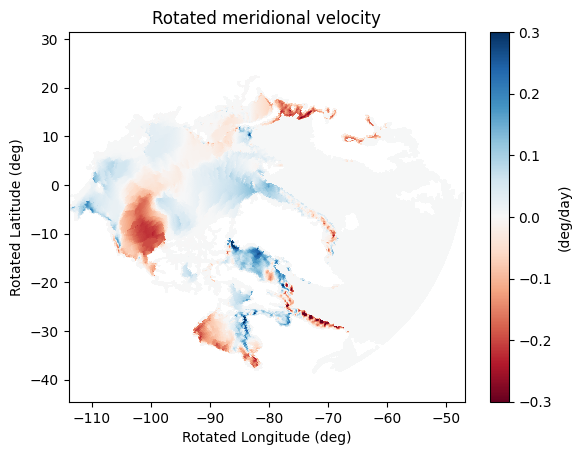

In [35]:
im = plt.pcolor(longitude_t_r[:,:], latitude_t_r[:,:], vlat_r[:,:,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated meridional velocity')

#### Comparable to the old x-component of the velocity (siu)

Text(0.5, 1.0, 'x-component of the velocity (siu)')

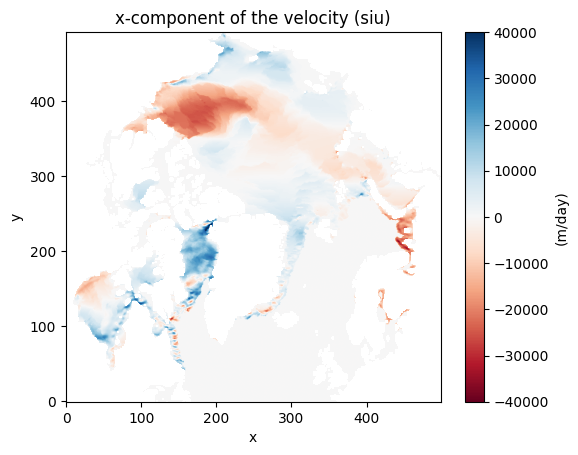

In [36]:
im = imshow(siu[:,:,0],cmap=cm.RdBu,origin="lower",vmin=-40000, vmax=40000)
cbar = plt.colorbar(im)
cbar.set_label("(m/day)")
plt.ylabel('y')
plt.xlabel('x')
plt.title('x-component of the velocity (siu)')


### Rotated zonal velocity in degrees/day

/tmp/ipykernel_6626/1037097249.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = plt.pcolor(longitude_t_r[:,:], latitude_t_r[:,:], vlon_r[:,:,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
/tmp/ipykernel_6626/1037097249.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im)


Text(0.5, 1.0, 'Rotated zonal velocity')

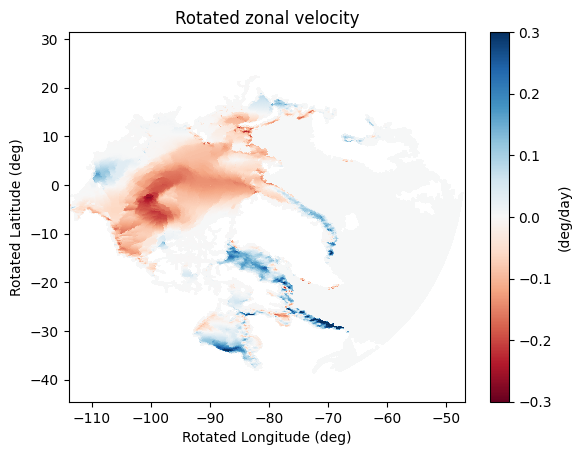

In [37]:
im = plt.pcolor(longitude_t_r[:,:], latitude_t_r[:,:], vlon_r[:,:,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated zonal velocity')

#### Comparable to the y-component of the velocity (siv)

Note the change of sign in the velocity field. This is due to the fact that while the y grid component is growing along the y direction Greenland-Bering strait, the rotated longitude component decreases.

Text(0.5, 1.0, 'y-component of the velocity (siv)')

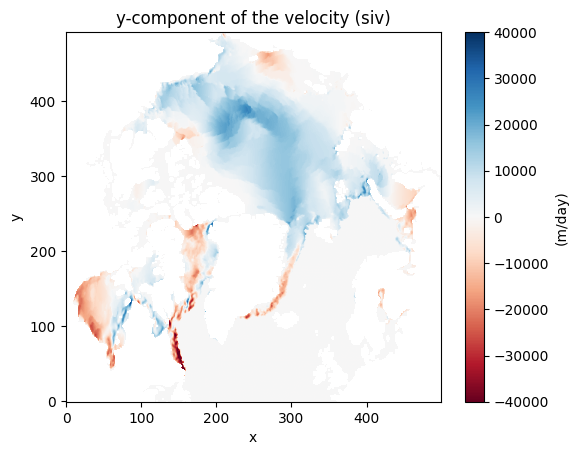

In [38]:
im = imshow(siv[:,:,0],cmap=cm.RdBu,origin="lower",vmin=-40000, vmax=40000)
cbar = plt.colorbar(im)
cbar.set_label("(m/day)")
plt.ylabel('y')
plt.xlabel('x')
plt.title('y-component of the velocity (siv)')

### Closer look to what we have in the NP for the rotated zonal velocity component to check if we still have artifact

Thinks to take into account:

    1. I'm only showing the zonal component but it looks the same for the rotated meridional coponent.
    2. The order of magnitude of the artifact is $10^{-3} deg/day$. Each cell around the NP more or less represents $0.1 deg$ so the error introduced will be minimum.
    3. Contrary to what I wrote in the mail, the artifact spreads to more than one cell but I think I understand why. It comes from the differenciation and the fact that there is not only one cell representing the NP but several. We can discuss that!!


##### With the same colormap scale as the global-Arctic maps

Text(0.5, 1.0, 'Rotated zonal velocity')

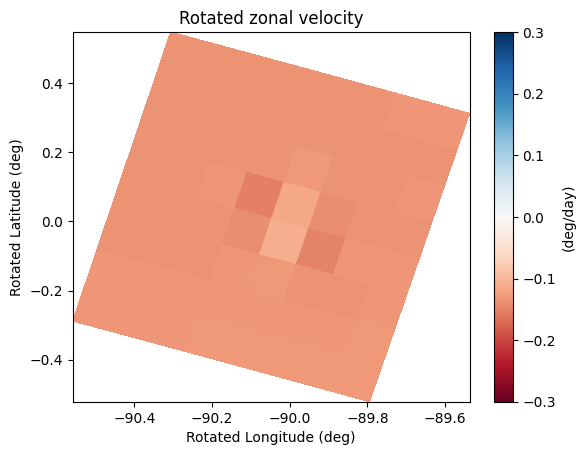

In [39]:
im = plt.pcolor(longitude_t_r[302:310,282:290], latitude_t_r[302:310,282:290], vlon_r[302:310,282:290,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated zonal velocity')

#### Adapted colormap scale to see the order of magnitude of the artifact 

Order of magnitude of the artifact: $10^{-3}$

Text(0.5, 1.0, 'Rotated zonal velocity')

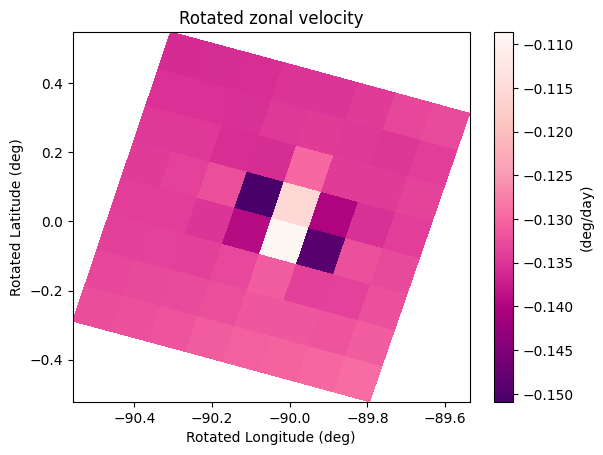

In [40]:
im = plt.pcolor(longitude_t_r[302:310,282:290], latitude_t_r[302:310,282:290], vlon_r[302:310,282:290,0],cmap=cm.RdPu_r)#,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated zonal velocity')

##### A bit less zoom
Thee artifact is not so visible anymore!

Text(0.5, 1.0, 'Rotated zonal velocity')

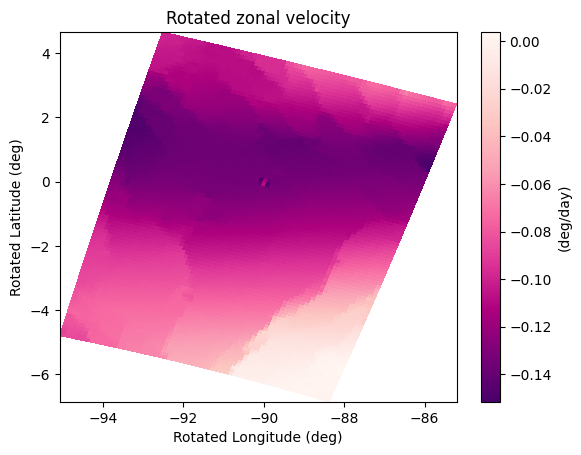

In [41]:
im = plt.pcolor(longitude_t_r[270:340,230:320], latitude_t_r[270:340,230:320], vlon_r[270:340,230:320,0],cmap=cm.RdPu_r)#,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated zonal velocity')

#### Mask and iterpolate a 8x8 square around the NP to remove the artifact in the vlat and vlon fields

In [42]:
# Define the row and column indices for positions to set to NaN (8x8 squared)
dlatxdx_r[300:310,280:290] = np.nan
dlatydy_r[300:310,280:290] = np.nan
dlonxdx_r[300:310,280:290] = np.nan
dlonydy_r[300:310,280:290] = np.nan
# Create a grid of coordinates
x, y = np.meshgrid(np.arange(dlatxdx_r.shape[1]), np.arange(dlatxdx_r.shape[0]))
# Masked array where the value is NaN
masked_array_dlatxdx = np.isnan(dlatxdx_r)
masked_array_dlatydy = np.isnan(dlatydy_r)
masked_array_dlonxdx = np.isnan(dlonxdx_r)
masked_array_dlonydy = np.isnan(dlonydy_r)
# Get the valid points (not NaN)
valid_points_dlatxdx = ~masked_array_dlatxdx
valid_points_dlatydy = ~masked_array_dlatydy
valid_points_dlonxdx = ~masked_array_dlonxdx
valid_points_dlonydy = ~masked_array_dlonydy
# Extract the coordinates and values of the valid points
valid_x_dlatxdx = x[valid_points_dlatxdx]
valid_y_dlatxdx = y[valid_points_dlatxdx]
valid_latx_values = dlatxdx_r[valid_points_dlatxdx]
valid_x_dlatydy = x[valid_points_dlatydy]
valid_y_dlatydy = y[valid_points_dlatydy]
valid_laty_values = dlatydy_r[valid_points_dlatydy]
valid_x_dlonxdx = x[valid_points_dlonxdx]
valid_y_dlonxdx = y[valid_points_dlonxdx]
valid_lonx_values = dlonxdx_r[valid_points_dlonxdx]
valid_x_dlonydy = x[valid_points_dlonydy]
valid_y_dlonydy = y[valid_points_dlonydy]
valid_lony_values = dlonydy_r[valid_points_dlonydy]
# Interpolate the missing value
dlatxdx_r_interpolated = griddata(
    (valid_x_dlatxdx, valid_y_dlatxdx), valid_latx_values, (x, y), method='cubic'
)
dlatydy_r_interpolated = griddata(
    (valid_x_dlatydy, valid_y_dlatydy), valid_laty_values, (x, y), method='cubic'
)
dlonxdx_r_interpolated = griddata(
    (valid_x_dlonxdx, valid_y_dlonxdx), valid_lonx_values, (x, y), method='cubic'
)
dlonydy_r_interpolated = griddata(
    (valid_x_dlonydy, valid_y_dlonydy), valid_lony_values, (x, y), method='cubic'
)
# Replace the original NaN value with the interpolated value
dlatxdx_r[masked_array_dlatxdx] = dlatxdx_r_interpolated[masked_array_dlatxdx]
dlatydy_r[masked_array_dlatydy] = dlatydy_r_interpolated[masked_array_dlatydy]
dlonxdx_r[masked_array_dlonxdx] = dlonxdx_r_interpolated[masked_array_dlonxdx]
dlonydy_r[masked_array_dlonydy] = dlonydy_r_interpolated[masked_array_dlonydy]

### REPEATED CODE!!!
# Transforming the velocities

Here we use the Jacobian to transform the  x-y velocity components to rot_lat-rot_lon velocity components. This is
$$
\begin{bmatrix}
v_{\text{lat}} \\
v_{\text{lon}}
\end{bmatrix}
= J \cdot
\begin{bmatrix}
v_x \\
v_y
\end{bmatrix}$$
Resulting Equations:

$v_{\text{lat}} = \frac{\partial \text{lat}}{\partial x} \cdot v_x + \frac{\partial \text{lat}}{\partial y} \cdot v_y$

$v_{\text{lon}} = \frac{\partial \text{lon}}{\partial x} \cdot v_x + \frac{\partial \text{lon}}{\partial y} \cdot v_y$

In [43]:
vlat_r = np.multiply(dlatxdx_r[:, :, np.newaxis],siu) + np.multiply(dlatydy_r[:, :, np.newaxis],siv)
vlon_r = np.multiply(dlonxdx_r[:, :, np.newaxis],siu) + np.multiply(dlonydy_r[:, :, np.newaxis],siv)

Text(0.5, 1.0, 'Rotated zonal velocity')

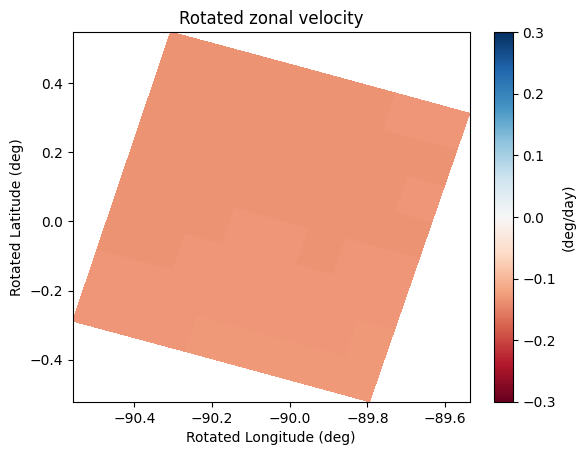

In [44]:
im = plt.pcolor(longitude_t_r[302:310,282:290], latitude_t_r[302:310,282:290], vlon_r[302:310,282:290,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated zonal velocity')

Text(0.5, 1.0, 'Rotated zonal velocity')

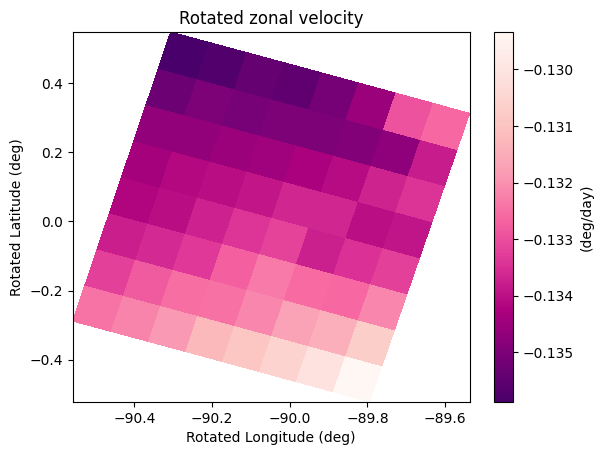

In [45]:
im = plt.pcolor(longitude_t_r[302:310,282:290], latitude_t_r[302:310,282:290], vlon_r[302:310,282:290,0],cmap=cm.RdPu_r)#,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated zonal velocity')

##### A bit less zoom
The artifact is almost $100\%$ gone

Text(0.5, 1.0, 'Rotated zonal velocity')

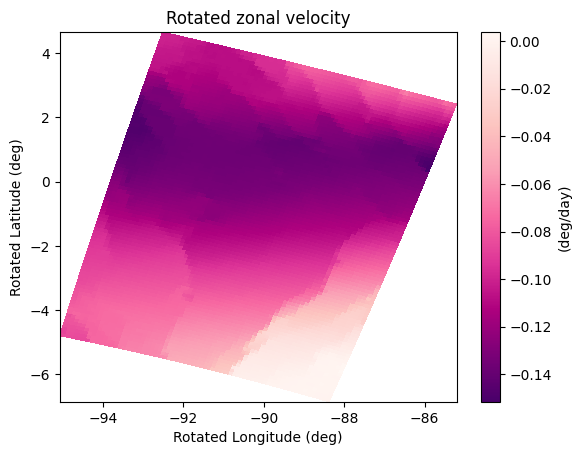

In [46]:
im = plt.pcolor(longitude_t_r[270:340,230:320], latitude_t_r[270:340,230:320], vlon_r[270:340,230:320,0],cmap=cm.RdPu_r)#,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated zonal velocity')

Text(0.5, 1.0, 'Rotated meridional velocity')

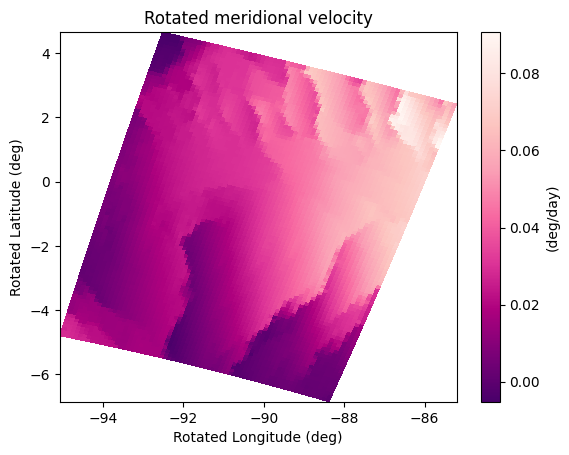

In [47]:
im = plt.pcolor(longitude_t_r[270:340,230:320], latitude_t_r[270:340,230:320], vlat_r[270:340,230:320,0],cmap=cm.RdPu_r)#,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated meridional velocity')

#### The whole Arctic

/tmp/ipykernel_6626/2266857598.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = plt.pcolor(longitude_t_r[:,:], latitude_t_r[:,:],vlon_r[:,:,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
/tmp/ipykernel_6626/2266857598.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im)


Text(0.5, 1.0, 'Rotated zonal velocity')

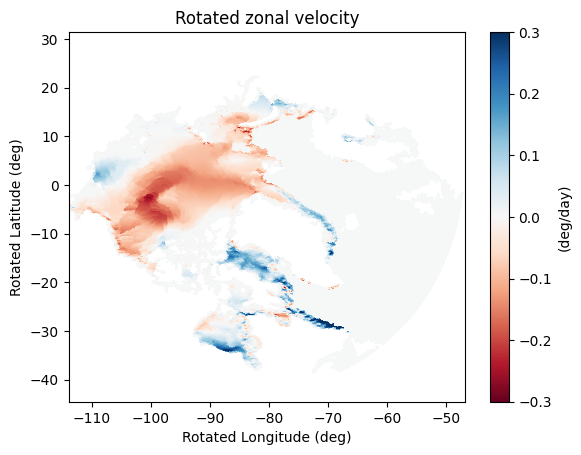

In [48]:
im = plt.pcolor(longitude_t_r[:,:], latitude_t_r[:,:],vlon_r[:,:,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated zonal velocity')

/tmp/ipykernel_6626/1604059432.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = plt.pcolor(longitude_t_r[:,:], latitude_t_r[:,:],vlat_r[:,:,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
/tmp/ipykernel_6626/1604059432.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im)


Text(0.5, 1.0, 'Rotated meridional velocity')

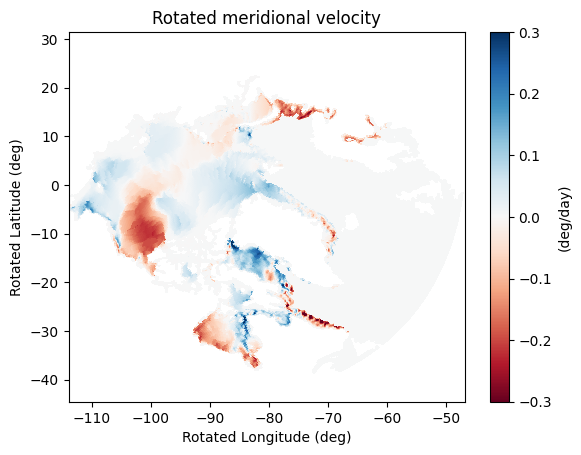

In [49]:
im = plt.pcolor(longitude_t_r[:,:], latitude_t_r[:,:],vlat_r[:,:,0],cmap=cm.RdBu,vmin=-0.3, vmax=0.3)
cbar = plt.colorbar(im)
cbar.set_label("(deg/day)")
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated meridional velocity')

### Comparison between non-rotated and rotated coordinates to understand what we are doing

### Transformed latitude

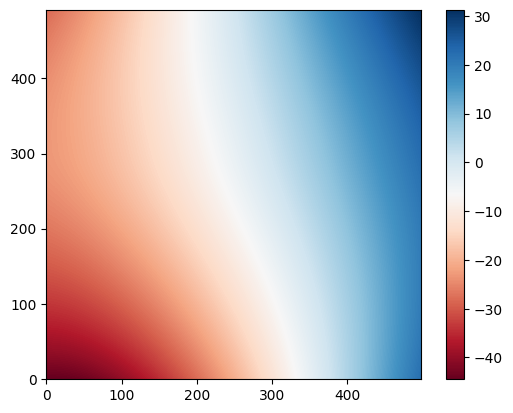

In [50]:
im = imshow( latitude_t_r[:,:],cmap=cm.RdBu,origin="lower") #,vmax=30000,vmin=-30000)
plt.colorbar(im)

### Normal Latitude

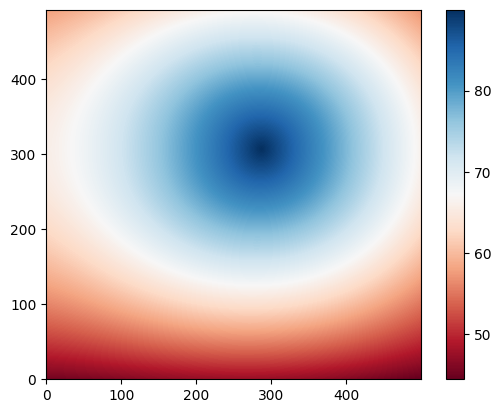

In [51]:
im = imshow( latitude_t[:,:],cmap=cm.RdBu,origin="lower") #,vmax=30000,vmin=-30000)
plt.colorbar(im)

### Transformed longitude

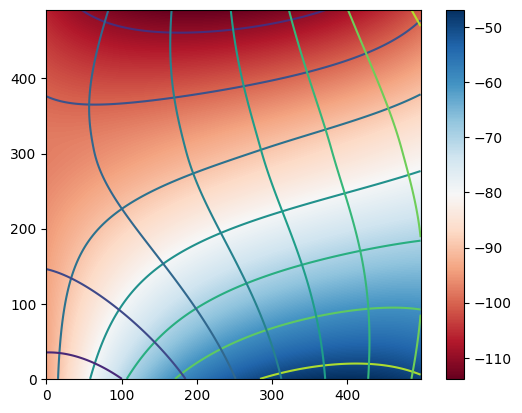

In [52]:
im = imshow( longitude_t_r[:,:],cmap=cm.RdBu,origin="lower") #,vmax=30000,vmin=-30000)
plt.colorbar(im)
plt.contour(longitude_t_r)
plt.contour(latitude_t_r)

### Normal longitude

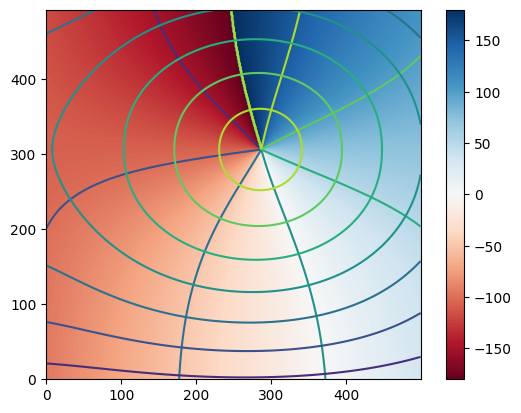

In [53]:
im = imshow(longitude_t[:,:],cmap=cm.RdBu,origin="lower") #,vmax=30000,vmin=-30000)
plt.contour(longitude_t)
plt.contour(latitude_t)
plt.colorbar(im)

In [54]:
x = np.cumsum(e1u,axis=1)[1:493,1:500]
y = np.cumsum(e2v,axis=0)[1:493,1:500]

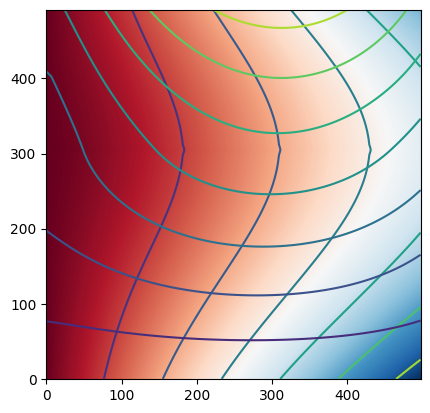

In [55]:
im = imshow(x[:,:],cmap=cm.RdBu,origin='lower') #,vmin=-0.3, vmax=0.3)
plt.contour(x)
plt.contour(y)


### Comparing velocity fields 

In [56]:
longitude_t= longitude_t[1:493,1:500]
latitude_t = latitude_t[1:493,1:500]

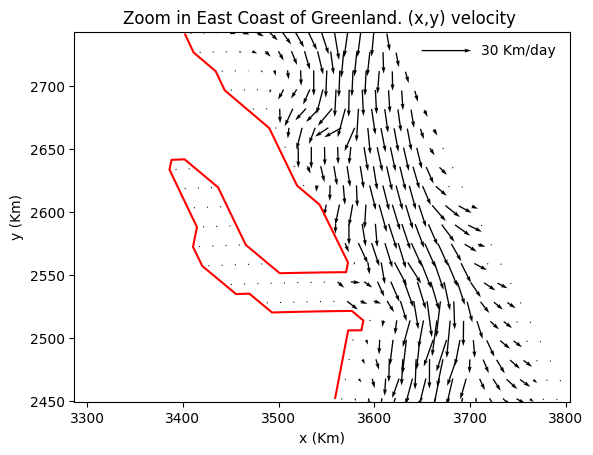

In [57]:
a = (slice(140, 160), slice(270, 295))
a_v = (slice(140, 160), slice(270, 295),0)
origin = np.array([x[a].ravel()/1000,y[a].ravel()/1000]) # origin point
Q = plt.quiver(*origin, siu[a_v].ravel(), siv[a_v].ravel(), scale=300000)
plt.contour(x[a]/1000,y[a]/1000,siu[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('y (Km)')
plt.xlabel('x (Km)')
plt.quiverkey(Q, X=0.8, Y=0.95, U=30000, label='30 Km/day', labelpos='E')
plt.title("Zoom in East Coast of Greenland. (x,y) velocity ")
plt.savefig("Greenland_xy.png")

Text(0.5, 1.0, 'Zoom in East coast of Greenland. (lat_r,lon_r velocity)')

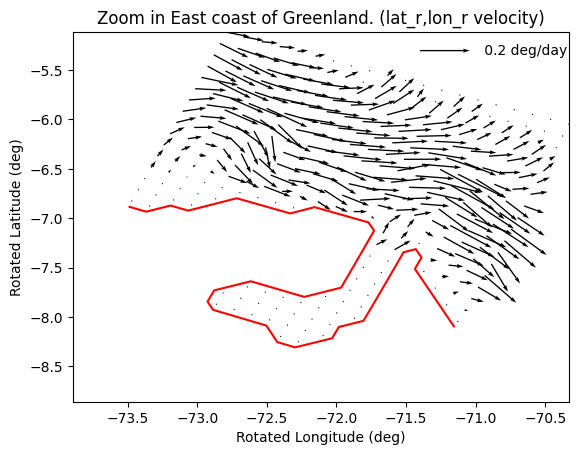

In [58]:
a = (slice(140, 160), slice(270, 295))
a_v = (slice(140, 160), slice(270, 295),0)
origin = np.array([longitude_t_r[a].ravel(),latitude_t_r[a].ravel()]) # origin point
Q = plt.quiver(*origin, vlon_r[a_v].ravel(), vlat_r[a_v].ravel(), scale=2)
plt.quiverkey(Q, X=0.8, Y=0.95, U=0.2, label=' 0.2 deg/day', labelpos='E')
plt.contour(longitude_t_r[a],latitude_t_r[a],vlat_r[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title("Zoom in East coast of Greenland. (lat_r,lon_r velocity)")


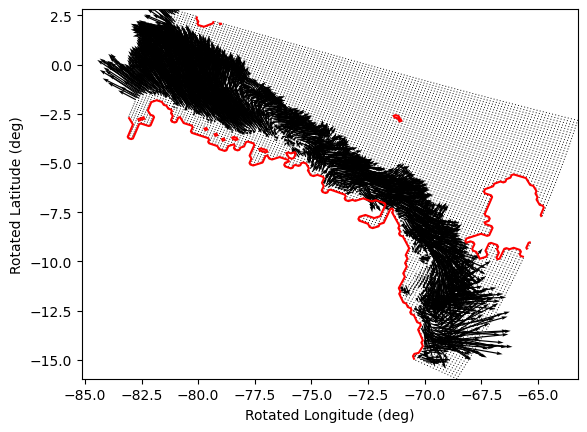

In [59]:
a = (slice(100, 240), slice(230, 335))
a_v = (slice(100, 240), slice(230, 335),0)
origin = np.array([longitude_t_r[a].ravel(),latitude_t_r[a].ravel()]) # origin point
S = plt.quiver(*origin, vlon_r[a_v].ravel(), vlat_r[a_v].ravel(), scale=2)
plt.contour(longitude_t_r[a],latitude_t_r[a],vlat_r[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.quiverkey(S, X=0.8, Y=1.05, U=3, label='30 Km/day', labelpos='E')


Text(0.5, 1.0, 'Zoom in Novaya Zemlya. (lat_r,lon_r velocity)')

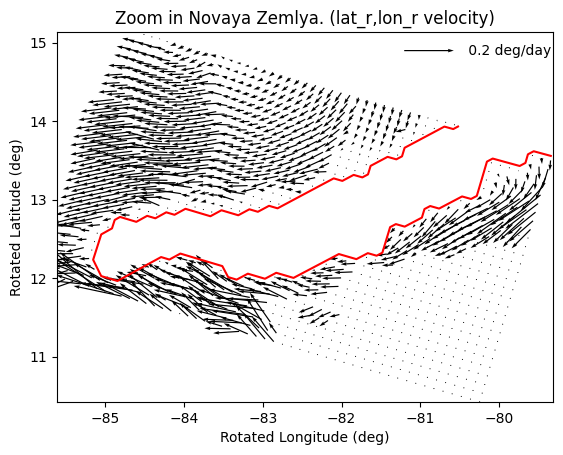

In [60]:
a = (slice(250, 300), slice(400, 430))
a_v = (slice(250, 300), slice(400, 430),0)
origin = np.array([longitude_t_r[a].ravel(),latitude_t_r[a].ravel()]) # origin point
Q=plt.quiver(*origin, vlon_r[a_v].ravel(), vlat_r[a_v].ravel(), scale=2)
plt.quiverkey(Q, X=0.8, Y=0.95, U=0.2, label=' 0.2 deg/day', labelpos='E')
plt.contour(longitude_t_r[a],latitude_t_r[a],vlat_r[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title("Zoom in Novaya Zemlya. (lat_r,lon_r velocity)")


Text(0.5, 1.0, 'Zoom in Novaya Zemlya. (x,y) velocity')

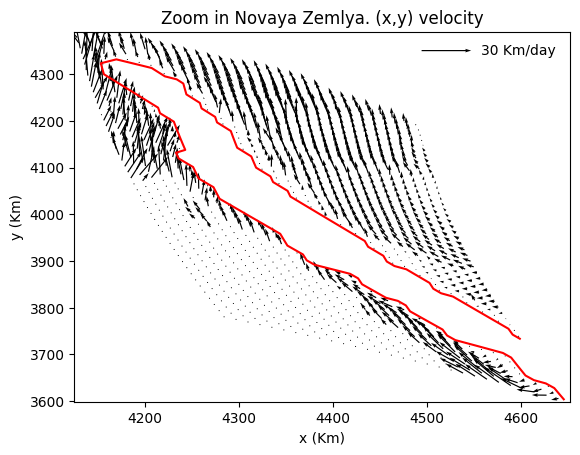

In [61]:
a = (slice(250, 300), slice(400, 430))
a_v = (slice(250, 300), slice(400, 430),0)
origin = np.array([x[a].ravel()/1000,y[a].ravel()/1000]) # origin point
Q = plt.quiver(*origin, siu[a_v].ravel(), siv[a_v].ravel(), scale=300000)
plt.contour(x[a]/1000,y[a]/1000,siu[a_v].mask, levels=[0.5], colors='red')
plt.quiverkey(Q, X=0.8, Y=0.95, U=30000, label='30 Km/day', labelpos='E')
plt.ylabel('y (Km)')
plt.xlabel('x (Km)')
plt.title("Zoom in Novaya Zemlya. (x,y) velocity")

Text(0.5, 0, 'Rotated Longitude (deg)')

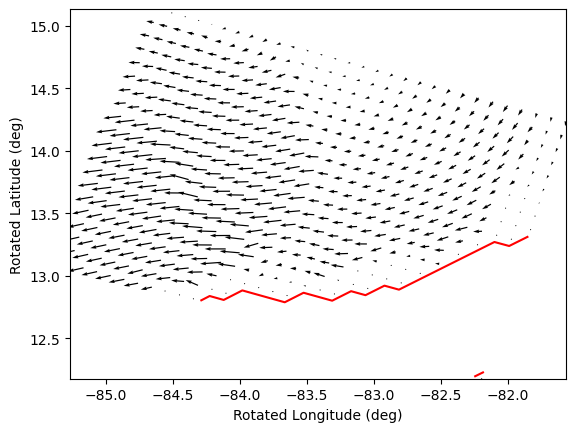

In [62]:
a = (slice(270, 300), slice(410, 430))
a_v = (slice(270, 300), slice(410, 430),0)
origin = np.array([longitude_t_r[a].ravel(),latitude_t_r[a].ravel()]) # origin point
plt.quiver(*origin, vlon_r[a_v].ravel(), vlat_r[a_v].ravel(), scale=3)
plt.contour(longitude_t_r[a],latitude_t_r[a],vlon_r[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')

Text(0.5, 0, 'x')

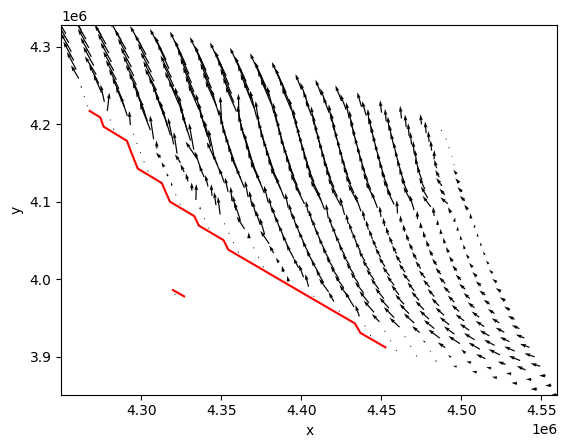

In [63]:
a = (slice(270, 300), slice(410, 430))
a_v = (slice(270, 300), slice(410, 430),0)
origin = np.array([x[a].ravel(),y[a].ravel()]) # origin point
plt.quiver(*origin, siu[a_v].ravel(), siv[a_v].ravel(), scale=240000)
plt.contour(x[a],y[a],siu[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('y')
plt.xlabel('x')

Text(0.5, 0, 'x')

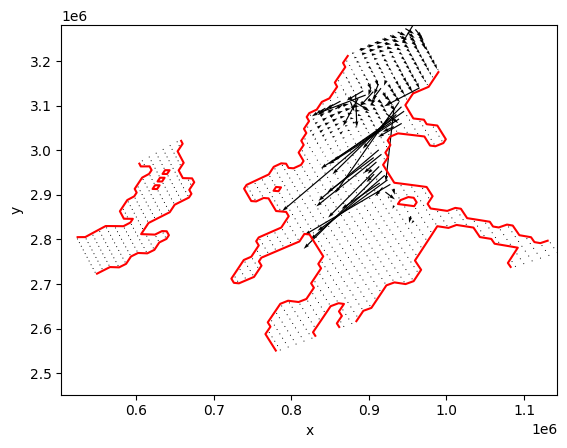

In [64]:
a = (slice(200, 250), slice(70, 120))
a_v = (slice(200, 250), slice(70, 120),0)
origin = np.array([x[a].ravel(),y[a].ravel()]) # origin point
plt.quiver(*origin, siu[a_v].ravel(), siv[a_v].ravel(), scale=40000)
plt.contour(x[a],y[a],siu[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('y')
plt.xlabel('x')

Text(0.5, 0, 'Rotated Longitude (deg)')

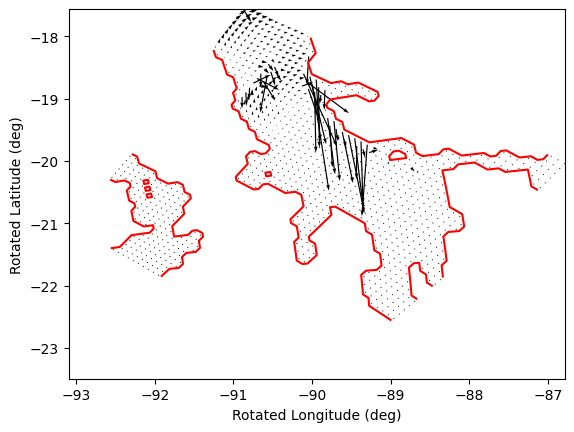

In [65]:
origin = np.array([longitude_t_r[a].ravel(),latitude_t_r[a].ravel()]) # origin point
plt.quiver(*origin, vlon_r[a_v].ravel(), vlat_r[a_v].ravel(), scale=0.5)
plt.contour(longitude_t_r[a],latitude_t_r[a],vlat_r[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')

Text(0.5, 0, 'x')

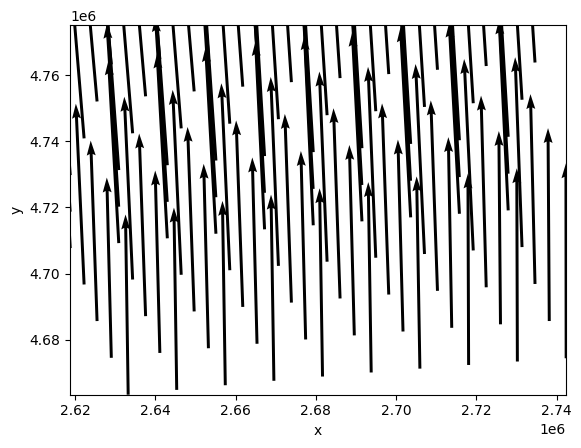

In [66]:
a = (slice(300, 310), slice(280, 290))
a_v = (slice(300, 310), slice(280, 290),0)
origin = np.array([x[a].ravel(),y[a].ravel()]) # origin point
plt.quiver(*origin, siu[a_v].ravel(), siv[a_v].ravel(), scale=40000)
plt.contour(x[a],y[a],siu[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('y')
plt.xlabel('x')

Text(0.5, 0, 'Rotated Longitude (deg)')

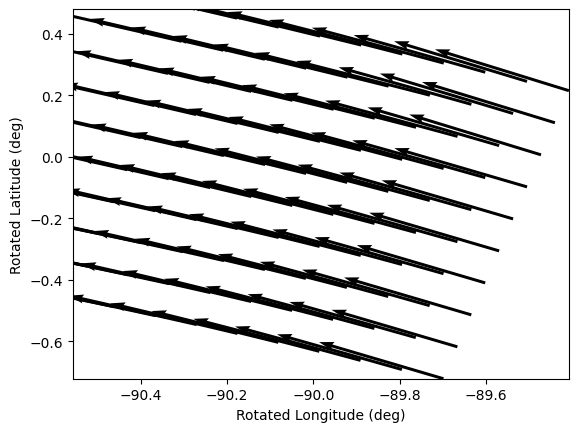

In [71]:
origin = np.array([longitude_t_r[a].ravel(),latitude_t_r[a].ravel()]) # origin point
plt.quiver(*origin, vlon_r[a_v].ravel(), vlat_r[a_v].ravel(), scale=0.5)
plt.contour(longitude_t_r[a],latitude_t_r[a],vlat_r[a_v].mask, levels=[0.5], colors='red')
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')

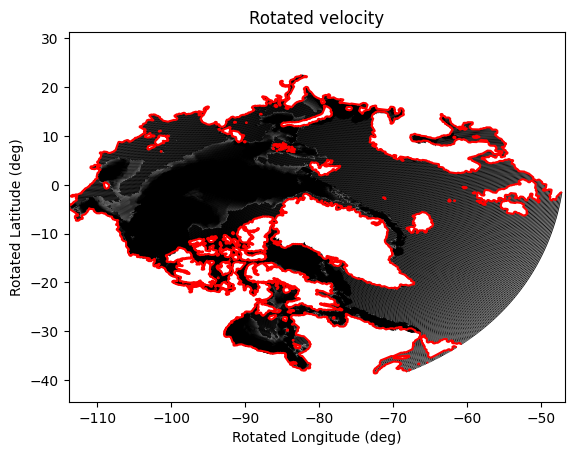

In [40]:
origin = np.array([longitude_t_r,latitude_t_r]) # origin point
plt.quiver(*origin, vlon_r[:,:,0], vlat_r[:,:,0], scale=21)
plt.contour(longitude_t_r,latitude_t_r,vlat_r[:,:,0].mask, levels=[0.5], colors='red')
plt.ylabel('Rotated Latitude (deg)')
plt.xlabel('Rotated Longitude (deg)')
plt.title('Rotated velocity')
plt.show()

Text(0.5, 0, 'x')

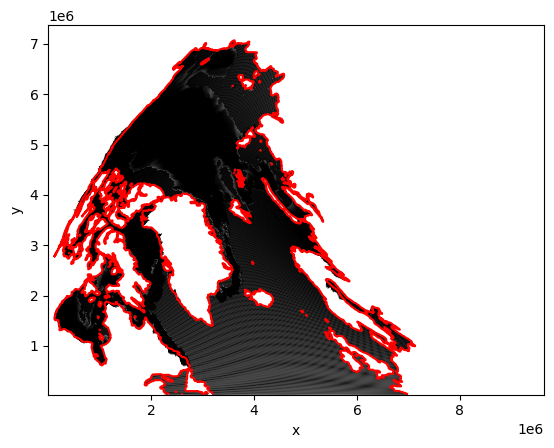

In [41]:
origin = np.array([x,y]) # origin point
plt.quiver(*origin, siu[:,:,0], siv[:,:,0], scale=2000000)
plt.contour(x,y,siu[:,:,0].mask, levels=[0.5], colors='red')
plt.ylabel('y')
plt.xlabel('x')

### Save the velocity field to a NetCDF file

In [42]:
V=v

NameError: name 'v' is not defined

In [47]:
out_path = results_directory+'/OPA-neXtSIM_CREG025_ILBOXE140_2010_ice_latlon_rot_jacob.nc'  
# Create a new NetCDF file
ncfile = Dataset(out_path, 'w', format='NETCDF4')
y_size = latitude_t_r.shape[0]
x_size = latitude_t_r.shape[1]
time_size = time_data.shape[0]
# Create dimensions
ncfile.createDimension('time', None)
ncfile.createDimension('y', y_size)
ncfile.createDimension('x', x_size)
#ncfile.createDimension('nv', 2)
# Create variables
time_var = ncfile.createVariable('time', np.float64, ('time',))
time_var.standard_name = "time"
time_var.long_name = "simulation time"
time_var.units = "days since 1900-01-01 00:00:00"
time_var.calendar = "standard"
time_var.bounds = "time_bnds"
#time_bnds_var = ncfile.createVariable('time_bnds', np.float64, ('time', 'nv'))
#time_bnds_var.units = "days since 1900-01-01 00:00:00"
latitude_var = ncfile.createVariable('rot_lat', np.float32, ('y','x'),fill_value=latitude_t.fill_value)
latitude_var.standard_name = " rotated latitude"
latitude_var.long_name = "latitude wrt the coordinate system rotated 90⁰ clockwise around the x axis. NP in y=-1, z=0"
longitude_var = ncfile.createVariable('rot_lon', np.float32, ('y','x'),fill_value=longitude_t.fill_value)
longitude_var.standard_name = " rotated longitude"
longitude_var.long_name = "longitude wrt the coordinate system rotated 90⁰ clockwise around the x axis. NP in y=-1, z=0"
vlon_var = ncfile.createVariable('vlon', np.float32, ('time','y', 'x'),fill_value=vlon_r.fill_value)
vlon_var.standard_name = "sea_ice_lon_velocity"
vlon_var.long_name = "Sea Ice Lon Velocity"
vlon_var.units = "deg day-1"
vlon_var.cell_methods = "time: mean (interval: 6 hours) area: mean"
vlat_var = ncfile.createVariable('vlat', np.float32, ('time', 'y', 'x'),fill_value=vlat_r.fill_value)
vlat_var.standard_name = "sea_ice_lat_velocity"
vlat_var.long_name = "Sea Ice Lat Velocity"
vlat_var.units = "deg day-1"
vlat_var.cell_methods = "time: mean (interval: 6 hours) area: mean"
# Assign data to variables
latitude_var[:,:] = latitude_t_r
longitude_var[:,:] = longitude_t_r
time_var[:] = time_data
vlat_var[:, :, :] = np.transpose(vlat_r, axes=(2,0,1))
vlon_var[:, :, :] = np.transpose(vlon_r, axes=(2,0,1))
# Add global attributes
ncfile.Conventions = "CF-1.6"
ncfile.institution = "UiT, Institute of Mathematics and Statistics, Tromsø"
ncfile.source = "neXtSIM model fields + cartesian_to_rotated_latlon.ipynb"
# Close the file
ncfile.close()
print("NetCDF file created successfully.")

NetCDF file created successfully.
